In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

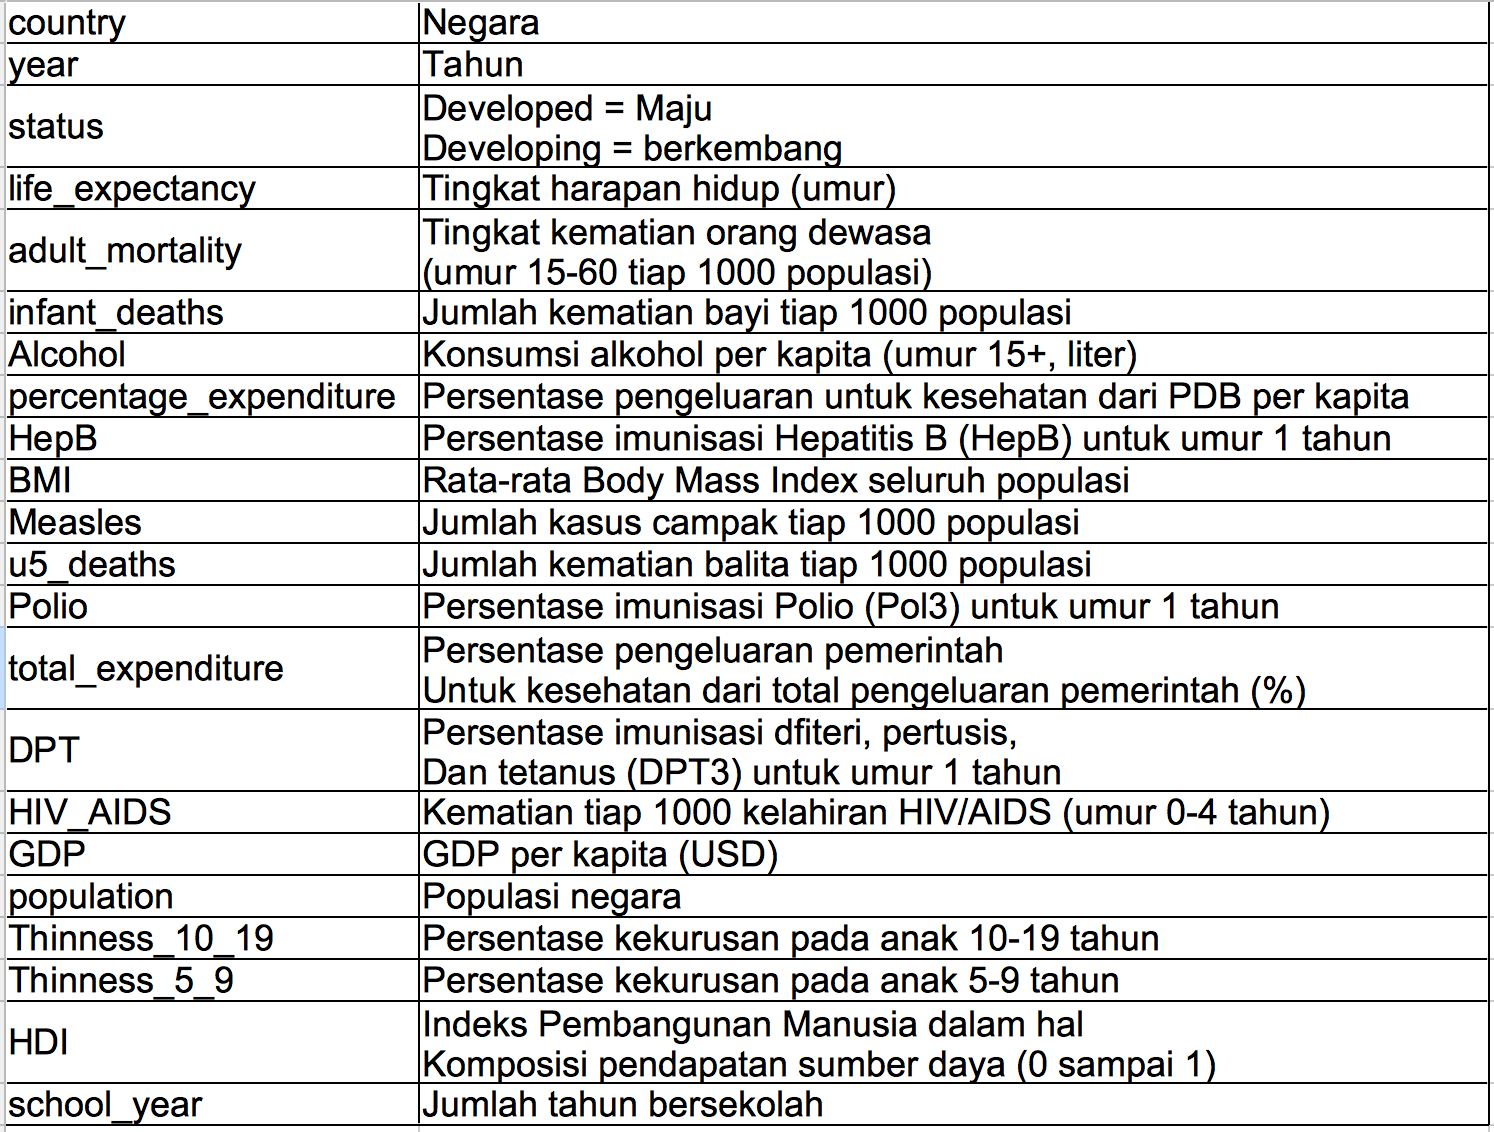

In [2]:
from luwiji.xgboost import illustration
illustration.nomenklatur

### Import Dataset

In [3]:
df = pd.read_csv("data/life_expectancy.csv")
df.head()

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,HepB,measles,...,Polio,total_expenditure,DPT,HIV_AIDS,GDP,population,thinness_10_19,thinness_5_9,HDI,school_year
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


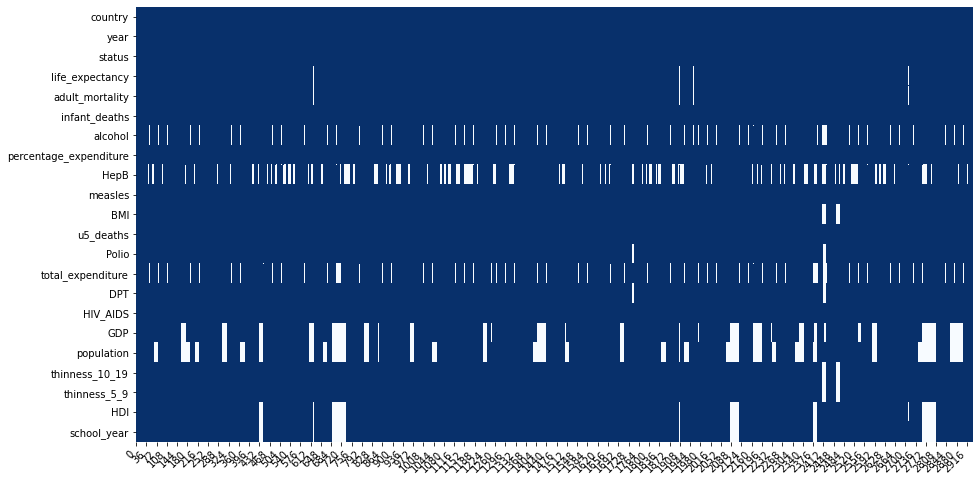

In [4]:
plot_missing_value(df)

In [5]:
df = df[~df.life_expectancy.isna()] #menghapus kolom target pada data yang kosong/bolong

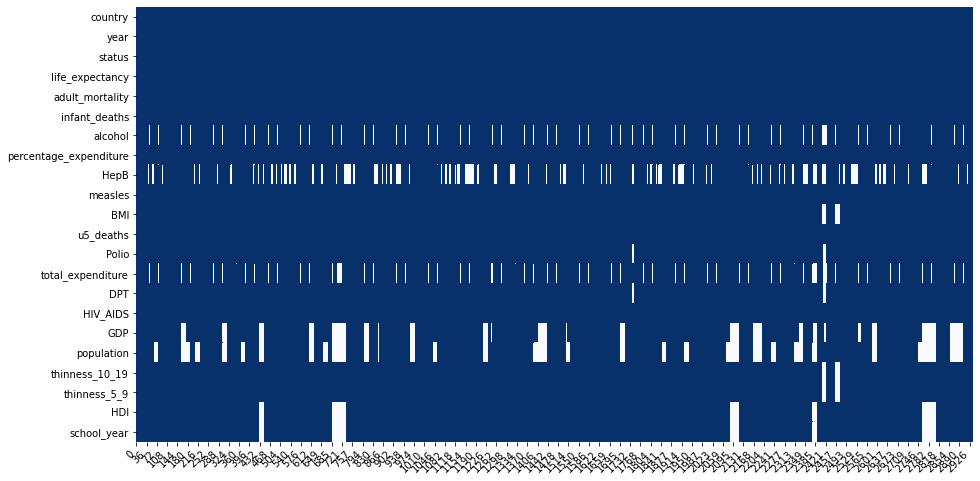

In [6]:
plot_missing_value(df)

### Dataset Spliting

In [7]:
X = df.drop(columns="life_expectancy")
y = df.life_expectancy

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2342, 21), (586, 21), (2342,), (586,))

### Training

In [11]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp
from jcopml.tuning.space import Integer, Real

In [12]:
X_train.columns

Index(['country', 'year', 'status', 'adult_mortality', 'infant_deaths',
       'alcohol', 'percentage_expenditure', 'HepB', 'measles', 'BMI',
       'u5_deaths', 'Polio', 'total_expenditure', 'DPT', 'HIV_AIDS', 'GDP',
       'population', 'thinness_10_19', 'thinness_5_9', 'HDI', 'school_year'],
      dtype='object')

In [13]:
rsp.xgb_params

{'algo__max_depth': Integer(low=1, high=10),
 'algo__learning_rate': Real(low=-2, high=0, prior='log-uniform'),
 'algo__n_estimators': Integer(low=100, high=200),
 'algo__subsample': Real(low=0.3, high=0.8, prior='uniform'),
 'algo__gamma': Integer(low=1, high=10),
 'algo__colsample_bytree': Real(low=0.1, high=1, prior='uniform'),
 'algo__reg_alpha': Real(low=-3, high=1, prior='log-uniform'),
 'algo__reg_lambda': Real(low=-3, high=1, prior='log-uniform')}

In [15]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['year','adult_mortality','infant_deaths',
       'alcohol', 'percentage_expenditure', 'HepB', 'measles', 'BMI',
       'u5_deaths', 'Polio', 'total_expenditure', 'DPT', 'HIV_AIDS', 'GDP',
       'population', 'thinness_10_19', 'thinness_5_9', 'HDI', 'school_year']),
    ('categoric', cat_pipe(encoder='onehot'), ['country','status']),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   48.4s finished


{'algo__colsample_bytree': 0.7545447962707789, 'algo__gamma': 8, 'algo__learning_rate': 0.13832094546570484, 'algo__max_depth': 9, 'algo__n_estimators': 161, 'algo__reg_alpha': 0.02001342062287998, 'algo__reg_lambda': 0.035868164986275514, 'algo__subsample': 0.43567451588694794}
0.9927819433674745 0.9570792139197071 0.9621878882471425


In [16]:
df.country.value_counts()

Singapore                                    16
Egypt                                        16
Madagascar                                   16
Cabo Verde                                   16
Mauritania                                   16
                                             ..
Jordan                                       16
Italy                                        16
Malawi                                       16
Republic of Moldova                          16
The former Yugoslav republic of Macedonia    16
Name: country, Length: 183, dtype: int64

### phase feature penting

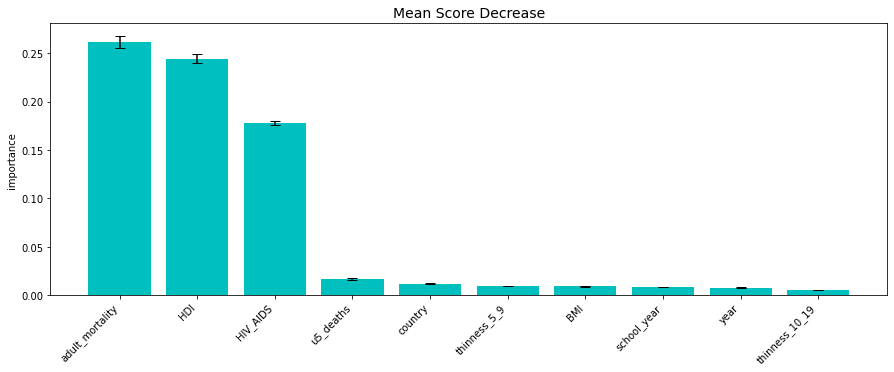

In [17]:
df_imp = mean_score_decrease(X_train,y_train, model, plot=True, topk=10)

In [18]:
list(df_imp.feature)[:5]

['adult_mortality', 'HDI', 'HIV_AIDS', 'u5_deaths', 'country']

In [20]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['adult_mortality', 'HDI', 'HIV_AIDS', 'u5_deaths', 'school_year'])
])
    

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   21.9s finished


{'algo__colsample_bytree': 0.7545447962707789, 'algo__gamma': 8, 'algo__learning_rate': 0.13832094546570484, 'algo__max_depth': 9, 'algo__n_estimators': 161, 'algo__reg_alpha': 0.02001342062287998, 'algo__reg_lambda': 0.035868164986275514, 'algo__subsample': 0.43567451588694794}
0.9895242120404992 0.9457948918380028 0.9556021558559882


### Poly

In [21]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2), ['adult_mortality', 'HDI', 'HIV_AIDS', 'u5_deaths', 'school_year'])
])
    

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_poly_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   36.5s finished


{'algo__colsample_bytree': 0.7273141668957412, 'algo__gamma': 6, 'algo__learning_rate': 0.05235791002299295, 'algo__max_depth': 10, 'algo__n_estimators': 125, 'algo__reg_alpha': 1.739616742284701, 'algo__reg_lambda': 2.9396070097391545, 'algo__subsample': 0.7566202762782357, 'prep__numeric__poly__degree': 2, 'prep__numeric__poly__interaction_only': True}
0.9813311663509688 0.9511652941893267 0.961340954678828
